In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages #Reducers ?

In [2]:
class State(TypedDict):


    messages:Annotated[list, add_messages]
graph_builder = StateGraph(State)

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()


True

In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm= ChatGroq(model="llama-3.1-8b-instant")

In [5]:
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x7a0581b75d50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7a0581ae4990>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
##Node Functionality
def chatboat(state:State):
    return {"messages": [llm.invoke(state["messages"])]}

In [7]:
graph_builder= StateGraph(State)
graph_builder.add_node("llmchatboat", chatboat)
graph_builder.add_edge(START,"llmchatboat")
graph_builder.add_edge("llmchatboat", END)

graph= graph_builder.compile()

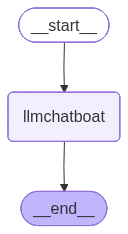

In [8]:
##visual graph
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [9]:
response =graph.invoke({"messages":"hi"})

In [10]:
response["messages"][-1].content

'How can I assist you today?'

In [11]:
for event in graph.stream({"messages":"Hi HOw are you?"}):
    print(event)

{'llmchatboat': {'messages': [AIMessage(content="I'm doing well, thank you for asking. I'm a large language model, so I don't have emotions or feelings like humans do, but I'm functioning properly and ready to assist you with any questions or tasks you may have. How can I help you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 41, 'total_tokens': 97, 'completion_time': 0.058504837, 'completion_tokens_details': None, 'prompt_time': 0.001913315, 'prompt_tokens_details': None, 'queue_time': 0.045235441, 'total_time': 0.060418152}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2bde-ba8f-7ab3-affe-b37e24b7f4c6-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 41, 'output_tokens': 56, 'total_tokens': 97})]}}


In [12]:
for event in graph.stream({"messages":"Hi HOw are you?"}): #type of streamig.Thanks
    
    for value in event.values():
        print(value["messages"][-1].content)

I'm just a computer program, so I don't have feelings like humans do, but I'm functioning properly and ready to help you with any questions or tasks you may have. How can I assist you today?


In [13]:
#cHATBOAT wITH tOOL

from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [14]:
#custome function

def multiply(a:int, b:int)->int:
    """Multiply a and b 
    Args:
        a(init): first int
        b(init): second int

    Returns:
        int: Output int

    """
    return a*b

In [15]:
tools = [tool, multiply]

In [16]:
llm_with_tool= llm.bind_tools(tools)

In [17]:
llm_with_tool

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x7a0581b75d50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7a0581ae4990>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a

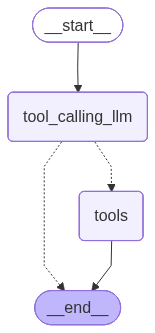

In [18]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Node Definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Normal edge
builder.add_edge(START, "tool_calling_llm")

# Conditional edge
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)

# After tools → back to llm (important)
# builder.add_edge("tools", "tool_calling_llm")

# End condition
builder.add_edge("tool_calling_llm", END)

# Compile
graph = builder.compile()


from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [19]:
response= graph.invoke({"messages": "What is the recent ai news"})

In [20]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.wsj.com/tech/ai/openclaw-ai-agents-moltbook-social-network-5b79ad65?gaa_at=eafs&gaa_n=AWEtsqfYE0W9wB6HyUSpdMQnh7bc6yQ2j8IqCqxww9yZ41IwjTLVrVGf0sAJ&gaa_ts=69838bd4&gaa_sig=Y1jlmqf5uGCBhugoaJcYOXYMo7MEPMMWZA80DRQcAotXkA-CUeAzGqs9Bb4dBuNLft1N5e8q8UKWnneTEYXxVg%3D%3D", "title": "The World’s First Viral AI Assistant Has Arrived, and Things Are Getting Weird - The Wall Street Journal", "score": 0.8449215, "published_date": "Wed, 04 Feb 2026 17:00:00 GMT", "content": "Copyright ©2026 Dow Jones & Company, Inc. All Rights Reserved. 87990cbe856818d5eddac44c7b1cdeb8\\n\\nContinue reading your article with  \\na WSJ subscription\\n\\nSubscribe Now\\n\\nAlready a subscriber? Sign In\\n\\n## What to Read Next\\n\\nEXCLUSIVE\\n\\n### Varonis to Acquire AllTrue as AI Security Concerns Mount\\n\\n20 hours ago\\n\\nThe $125 million deal is the latest in a series of cyber acquisitions 

In [21]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (ak6q5w7xg)
 Call ID: ak6q5w7xg
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.wsj.com/tech/ai/openclaw-ai-agents-moltbook-social-network-5b79ad65?gaa_at=eafs&gaa_n=AWEtsqfYE0W9wB6HyUSpdMQnh7bc6yQ2j8IqCqxww9yZ41IwjTLVrVGf0sAJ&gaa_ts=69838bd4&gaa_sig=Y1jlmqf5uGCBhugoaJcYOXYMo7MEPMMWZA80DRQcAotXkA-CUeAzGqs9Bb4dBuNLft1N5e8q8UKWnneTEYXxVg%3D%3D", "title": "The World’s First Viral AI Assistant Has Arrived, and Things Are Getting Weird - The Wall Street Journal", "score": 0.8449215, "published_date": "Wed, 04 F

In [22]:
response = graph.invoke({"messages":"what is 2 multiply by 3"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2 multiply by 3
================================== Ai Message ==================================
Tool Calls:
  multiply (8zhd6t80a)
 Call ID: 8zhd6t80a
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [23]:
response = graph.invoke({"messages":"what is AI news ? and then multiply 2 by 3"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is AI news ? and then multiply 2 by 3
================================== Ai Message ==================================
Tool Calls:
  tavily_search (rkdm6pe56)
 Call ID: rkdm6pe56
  Args:
    query: AI news
    topic: news
  multiply (gs47wpx5v)
 Call ID: gs47wpx5v
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.foxnews.com/tech/ai-newsletter-amazon-cuts-thousands-roles", "title": "Fox News AI Newsletter: Amazon cuts thousands of roles - Fox News", "score": 0.99440175, "published_date": "Fri, 30 Jan 2026 15:57:49 GMT", "content": "* #### Fox News AI Newsletter: Historic infrastructure buildout for AI. # Fox News AI Newsletter: Amazon cuts thousands of roles. * Add Fox News on Google. ## Welcome to Fox News' Arti

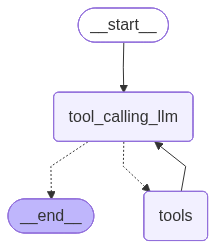

In [24]:
# React AGent 

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Node Definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Normal edge
builder.add_edge(START, "tool_calling_llm")

# Conditional edge
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)

# After tools → back to llm (important)
builder.add_edge("tools", "tool_calling_llm")

# End condition
builder.add_edge("tool_calling_llm", END)

# Compile
graph = builder.compile()


from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [25]:
response = graph.invoke({"messages":"what is AI news ? and then multiply 2 by 3"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is AI news ? and then multiply 2 by 3
================================== Ai Message ==================================
Tool Calls:
  tavily_search (v6551bj6a)
 Call ID: v6551bj6a
  Args:
    query: AI news
    time_range: day
    topic: news
  multiply (mhwjwrrf2)
 Call ID: mhwjwrrf2
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.wsj.com/tech/ai/openclaw-ai-agents-moltbook-social-network-5b79ad65?gaa_at=eafs&gaa_n=AWEtsqfYE0W9wB6HyUSpdMQnh7bc6yQ2j8IqCqxww9yZ41IwjTLVrVGf0sAJ&gaa_ts=69838bd4&gaa_sig=Y1jlmqf5uGCBhugoaJcYOXYMo7MEPMMWZA80DRQcAotXkA-CUeAzGqs9Bb4dBuNLft1N5e8q8UKWnneTEYXxVg%3D%3D", "title": "The World’s First Viral AI Assistant Has Arrived, and Things Are Getting Weird - The Wall Street Journal", "sco

In [26]:
#aDDING Memory in Agentic Graph
response = graph.invoke({"messages":"Hello my name is Rahul"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is Rahul
================================== Ai Message ==================================

Nice to meet you Rahul. How can I assist you today?


In [27]:
response = graph.invoke({"messages":"what is my name?"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is my name?
================================== Ai Message ==================================

I don't have any information about your name. I'm a large language model, I don't have the ability to know or access personal information about individuals unless you choose to share it with me.


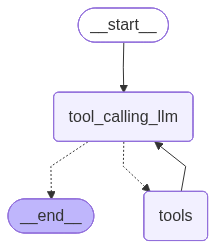

In [28]:
# React AGent 

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
memory = MemorySaver()

# Node Definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Normal edge
builder.add_edge(START, "tool_calling_llm")

# Conditional edge
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)

# After tools → back to llm (important)
builder.add_edge("tools", "tool_calling_llm")

# End condition
builder.add_edge("tool_calling_llm", END)

# Compile
graph = builder.compile(checkpointer=memory)


from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [29]:
config = {"configurable":{"thread_id":"1"}}
response=graph.invoke({"messages":"Hi my name is krish"},config=config)
response

{'messages': [HumanMessage(content='Hi my name is krish', additional_kwargs={}, response_metadata={}, id='41f6be05-be18-4b15-a2ad-da6b5f65df8f'),
  AIMessage(content="Nice to meet you, Krish! It's great to chat with you. Is there something I can help you with, or would you like to talk about something in particular?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 1775, 'total_tokens': 1811, 'completion_time': 0.049624251, 'completion_tokens_details': None, 'prompt_time': 0.122680452, 'prompt_tokens_details': None, 'queue_time': 0.052735872, 'total_time': 0.172304703}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2bdf-f359-7dd3-a8b3-4c410b0bd276-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1775, 'output_tokens': 36, 'total_tokens': 1811})]}

In [30]:
response['messages'][-1].content

"Nice to meet you, Krish! It's great to chat with you. Is there something I can help you with, or would you like to talk about something in particular?"

In [31]:
response=graph.invoke({"messages":"Hi what is my name"},config=config)
print(response['messages'][-1].content)

Your name is Krish.


In [32]:
# Striming techniq
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()


In [33]:
def superbot(state:State):
    return {"messages":[llm_with_tool.invoke(state['messages'])]}

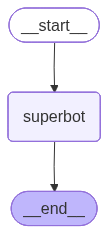

In [34]:

def superbot(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

builder = StateGraph(State)

# Nodes
builder.add_node("superbot", superbot)

# Edges
builder.add_edge(START, "superbot")
builder.add_edge("superbot", END)

# Compile
graph = builder.compile(checkpointer=memory)

# Visualize
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
config = {"configurable":{"thread_id":"1"}}
graph.invoke({"messages":"Hi my name is krish"},config)


{'messages': [HumanMessage(content='Hi my name is krish', additional_kwargs={}, response_metadata={}, id='d0d381bd-247f-4347-81d7-e02255b542ae'),
  AIMessage(content="It's nice to meet you, Krish. Is there anything I can help you with today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 1775, 'total_tokens': 1795, 'completion_time': 0.028623344, 'completion_tokens_details': None, 'prompt_time': 0.117406202, 'prompt_tokens_details': None, 'queue_time': 0.057939072, 'total_time': 0.146029546}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2be0-845e-7d81-a3f3-4343ac2fdf9a-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1775, 'output_tokens': 20, 'total_tokens': 1795})]}

In [36]:
config = {"configurable":{"thread_id":"1"}}
for chunk  in graph.stream({"messages":"Hi my name is Rahul and i like to play cricket"},config, stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content='Nice to meet you Rahul. Cricket is a fantastic sport, which team do you support?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1815, 'total_tokens': 1834, 'completion_time': 0.024658369, 'completion_tokens_details': None, 'prompt_time': 0.122049923, 'prompt_tokens_details': None, 'queue_time': 0.05178409, 'total_time': 0.146708292}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2be6-32be-75a1-acf4-e52a13220eb1-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1815, 'output_tokens': 19, 'total_tokens': 1834})]}}


In [37]:
config = {"configurable":{"thread_id":"1"}}
for chunk  in graph.stream({"messages":"Hi my name is Rahul and i like to play cricket"},config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is krish', additional_kwargs={}, response_metadata={}, id='d0d381bd-247f-4347-81d7-e02255b542ae'), AIMessage(content="It's nice to meet you, Krish. Is there anything I can help you with today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 1775, 'total_tokens': 1795, 'completion_time': 0.028623344, 'completion_tokens_details': None, 'prompt_time': 0.117406202, 'prompt_tokens_details': None, 'queue_time': 0.057939072, 'total_time': 0.146029546}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2be0-845e-7d81-a3f3-4343ac2fdf9a-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1775, 'output_tokens': 20, 'total_tokens': 1795}), HumanMessage(content='Hi my name is Rahul and i like to play cricket', additional_kwargs={}, respons

In [43]:
config = {"configurable":{"thread_id":"3"}}
for chunk  in graph.stream({"messages":"Hi my name is Rahul and i like to play cricket"},config, stream_mode="updates"):
    print(chunk)


{'superbot': {'messages': [AIMessage(content="You mentioned that before. Let's focus on something new. Would you like to know the current ranking of teams in the International Cricket Council (ICC) rankings?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 1985, 'total_tokens': 2018, 'completion_time': 0.06444025, 'completion_tokens_details': None, 'prompt_time': 0.162190898, 'prompt_tokens_details': None, 'queue_time': 0.068704923, 'total_time': 0.226631148}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2bec-1c38-71e3-ae40-42dba7b4edc5-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1985, 'output_tokens': 33, 'total_tokens': 2018})]}}


In [44]:
for chunk  in graph.stream({"messages":"i also like footbal"},config, stream_mode="values"):
    print(chunk)


{'messages': [HumanMessage(content='Hi my name is Rahul and i like to play cricket', additional_kwargs={}, response_metadata={}, id='e168c096-f4e7-4a04-81ff-715ce78852f2'), AIMessage(content="That's nice to hear. What would you like to talk about? Cricket?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 1780, 'total_tokens': 1797, 'completion_time': 0.039396068, 'completion_tokens_details': None, 'prompt_time': 0.118572641, 'prompt_tokens_details': None, 'queue_time': 0.063916899, 'total_time': 0.157968709}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2be8-ef78-7c92-a23b-d31ba1be39c7-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1780, 'output_tokens': 17, 'total_tokens': 1797}), HumanMessage(content='Hi my name is Rahul and i like to play cricket', additional_k

In [47]:
config = {"configurable":{"thread_id":"5"}}
for chunk  in graph.stream({"messages":"Hi my name is Rahul and i like to play cricket"},config, stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content="You mentioned that before. Let's focus on something new. If you like playing cricket, you might be interested in knowing some tips to improve your game. Would you like me to search for some cricket tips?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 2084, 'total_tokens': 2127, 'completion_time': 0.084577526, 'completion_tokens_details': None, 'prompt_time': 0.143765597, 'prompt_tokens_details': None, 'queue_time': 0.060537222, 'total_time': 0.228343123}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2bec-b8c3-7a92-bbec-eee6f9a05eef-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 2084, 'output_tokens': 43, 'total_tokens': 2127})]}}


In [63]:
#Human in the loop
from typing import Annotated
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages #Reducers ?
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
@tool
def human_assistance(query: str)->str:
    """Request assistance from a Human"""
    human_response = interrupt({"query":query})

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tool = llm.bind_tools(tools)

def chatboat(state:State):
    messages= llm_with_tool.invoke(state["messages"])
    return {"messages":[messages]}

graph_builder.add_node("chatboat", chatboat)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatboat", tools_condition,)
graph_builder.add_edge("tools", "chatboat")
graph_builder.add_edge(START, "chatboat")



In [64]:
graph = graph_builder.compile(checkpointer=memory)

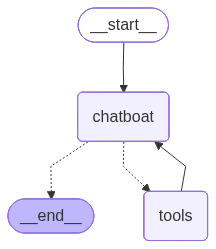

In [65]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [70]:
user_input = "i need some expert guidence assitance for building an AI agent. could you request assistance for me?"
config = {"configurable":{"thread_id":"1"}}
events = graph.stream({"messages": user_input}, config, stream_mode="values",)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

i need some expert guidence assitance for building an AI agent. could you request assistance for me?


================================== Ai Message ==================================
Tool Calls:
  human_assistance (5td0k4mz9)
 Call ID: 5td0k4mz9
  Args:
    query: Expert guidance for building an AI agent
================================== Ai Message ==================================
Tool Calls:
  human_assistance (5td0k4mz9)
 Call ID: 5td0k4mz9
  Args:
    query: Expert guidance for building an AI agent


In [87]:
human_response = ("we the experts are here to help we'd recomnded you check out langraph to build your agent it"
                  "event is much more reliable and extensible")
human_command = Command(resume={"data":human_response})
events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

<human_assistance>{"query": "LangGraph"}</function>


In [74]:
#Human in the loop
from typing import Annotated
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages #Reducers ?
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
@tool
def human_assistance(query: str)->str:
    """Request assistance from a Human"""
    human_response = interrupt({"query":query})

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tool = llm.bind_tools(tools)

def chatboat(state:State):
    messages= llm_with_tool.invoke(state["messages"])
    return {"messages":[messages]}

graph_builder.add_node("chatboat", chatboat)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatboat", tools_condition,)
graph_builder.add_edge("tools", "chatboat")
graph_builder.add_edge(START, "chatboat")

human_response = ("we the experts are here to help we'd recomnded you check out langraph to build your agent it"
                  "event is much more reliable and extensible")
human_command = Command(resume= {"data":human_response})
events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

You will need to wait for a human assistant to assist you.


In [86]:
human_response = (
    "We the experts are here to help. We'd recommend you check out LangGraph "
    "to build your agent — it is much more reliable and extensible."
)

human_command = Command(
    resume={
        "human_assistance": human_response
    }
)

events = graph.stream(human_command, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================== Ai Message ==================================

<human_assistance>{"query": "LangGraph"}</function>


In [76]:
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [HumanMessage(content="Tell me about LangGraph")]},
    config,
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================ Human Message =================================

Tell me about LangGraph
================================== Ai Message ==================================

<tavily_search>{"query": "LangGraph", "topic": "general"} </tavily_search>


In [77]:
human_response = (
    "We the experts are here to help. We'd recommend you check out LangGraph "
    "to build your agent — it is much more reliable and extensible."
)

human_command = Command(
    resume={
        "human_assistance": human_response
    }
)

events = graph.stream(
    human_command,
    config,
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================== Ai Message ==================================

<tavily_search>{"query": "LangGraph", "topic": "general"} </tavily_search>


In [78]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt

from langchain_core.messages import HumanMessage
from langchain_core.tools import tool


In [79]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


In [94]:
# @tool
# def human_assistance(query: str) -> str:
#     """Ask a human expert for help."""
#     response = interrupt({"query": query})
    # return response
@tool
def human_assistance(query: str) -> str:
    response = interrupt({"query": query})
    return response



ValueError: Function must have a docstring if description not provided.

In [95]:
tools = [human_assistance]
llm_with_tool = llm.bind_tools(tools)


In [96]:
def chatbot(state: State):
    msg = llm_with_tool.invoke(state["messages"])
    return {"messages": [msg]}


In [97]:
builder = StateGraph(State)

builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)


In [98]:
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [HumanMessage(content="Tell me about LangGraph")]},
    config,
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================ Human Message =================================

Tell me about LangGraph
================================== Ai Message ==================================

<brave_search>{ "query": "LangGraph" }</brave_search>
Tool Calls:
  human_assistance (hrmzy79ep)
 Call ID: hrmzy79ep
  Args:
    query: What is LangGraph and its features?
================================== Ai Message ==================================

<brave_search>{ "query": "LangGraph" }</brave_search>
Tool Calls:
  human_assistance (hrmzy79ep)
 Call ID: hrmzy79ep
  Args:
    query: What is LangGraph and its features?


In [99]:
human_response = (
    "LangGraph is a production-grade framework for building "
    "stateful, reliable, tool-using AI agents."
)

human_command = Command(
    resume={"human_assistance": human_response}
)

events = graph.stream(
    human_command,
    config,
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================== Ai Message ==================================

<brave_search>{ "query": "LangGraph" }</brave_search>
Tool Calls:
  human_assistance (hrmzy79ep)
 Call ID: hrmzy79ep
  Args:
    query: What is LangGraph and its features?
================================= Tool Message =================================
Name: human_assistance

{"human_assistance": "LangGraph is a production-grade framework for building stateful, reliable, tool-using AI agents."}


BadRequestError: Error code: 400 - {'error': {'message': "tool call validation failed: attempted to call tool 'brave_search' which was not in request.tools", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'It seems the response did not contain enough information to answer your question. Let me try again.\n\n<function=brave_search>{"query": "LangGraph features and usage"}</function>'}}